# House Price Prediction Using Random Forest

## Data Preprocessing and Feature Engineering

1. **Drop Unnecessary Columns**:
   - Removed irrelevant columns to simplify the dataset.
   - Converted `statezip` to an integer for better processing.

2. **Handle Missing Values**:
   - Dropped rows with missing values to ensure data quality.

3. **Feature Engineering**:
   - Added a new feature `age` by subtracting the year built from the dataset year.
   - Focused on the most important features for the model.

4. **Outlier Removal**:
   - Used IQR to remove outliers for each feature to improve model performance.

In [19]:
# Importing libraries and library functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import optuna

# Load the dataset
print("Loading the dataset")
data_path = 'data.csv'
df = pd.read_csv(data_path)

# Check dataset
print(df.info())
print("Data loaded successfully\n")

# Convert statezip to an integer for better processing
df['statezip'] = df['statezip'].apply(lambda x: int(x.split(' ')[1]) if pd.notnull(x) else np.nan)

# Handle missing values: Fill missing values with the median of each numeric column
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Convert date columns to datetime if necessary
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Feature Engineering: Add new features or transformations
df['age'] = 2014 - df['yr_built']  # Assuming the dataset is up to date to 2014

# Include all features for the model
features = df.drop(['price'], axis=1).columns

# Handle outliers based on IQR for each numeric feature
for feature in numeric_cols:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR)))]
print("Outliers removed")

# Drop non-numeric columns for correlation matrix
df_numeric = df.select_dtypes(include=[np.number])
print("Non-numeric columns dropped for correlation matrix")

Loading the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   o

## Display the Correlation Matrix
Visualize the correlation matrix to understand the relationships between features.


Displaying correlation matrix


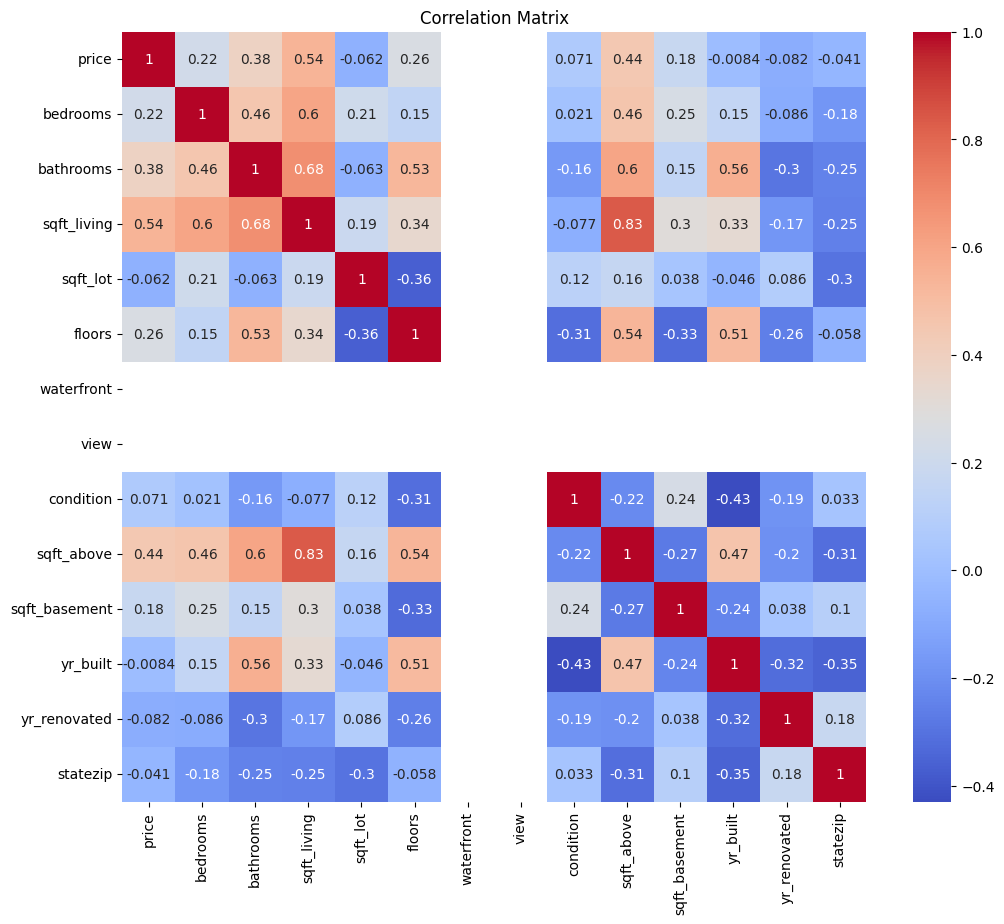

Correlation matrix displayed


In [20]:
# Display the correlation matrix
print("\nDisplaying correlation matrix")
plt.figure(figsize=(12, 10))
numeric_df = df[numeric_cols]
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
print("Correlation matrix displayed")

## Feature Scaling and Selection

1. **Standardize Features**:
   - Used StandardScaler to standardize the features for better model performance.

2. **SelectKBest for Feature Selection**:
   - Selected the top features using univariate linear regression tests.

In [21]:
# Re-integrate non-numeric columns after outlier removal
df = df.loc[df_numeric.index]
print("Non-numeric columns re-integrated after outlier removal")

# Feature Engineering: Add polynomial features and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[["sqft_living", "sqft_above", "sqft_basement"]])
poly_feature_names = poly.get_feature_names_out(["sqft_living", "sqft_above", "sqft_basement"])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
df = pd.concat([df, df_poly], axis=1)

# Define features and target
features = ["bedrooms", "bathrooms", "sqft_living", "floors", "statezip", "waterfront",
            "view", "sqft_above", "sqft_basement", "yr_renovated"] + list(poly_feature_names)
X = df[features]
y = df["price"]

Non-numeric columns re-integrated after outlier removal


## Model Training and Hyperparameter Tuning

1. **Train-Test Split**:
   - Split the data into training and testing sets.

2. **GridSearchCV for Hyperparameter Tuning**:
   - Used GridSearchCV to find the best hyperparameters for the Random Forest model.

In [22]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("Data split into training and test sets")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled")

# Train model
model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=15, min_samples_split=5, min_samples_leaf=2)
model.fit(X_train_scaled, y_train)

Data split into training and test sets
Features scaled


RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, random_state=42)

## Model Evaluation

1. **Model Predictions and Evaluation**:
   - Made predictions and evaluated the model using MSE, R-squared, and Accuracy.

2. **Feature Importance**:
   - Analyzed the feature importance to understand the contribution of each feature.

In [23]:
y_pred_final = model.predict(X_test_scaled)
print("\nTuned model (with Optuna) trained & predictions made")

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


Tuned model (with Optuna) trained & predictions made
Cross-Validation Scores: [0.66410774 0.6427131  0.63774365 0.66408133 0.68619264]
Mean CV Score: 0.66


## Visualization

1. **Plotting Actual vs Predicted Prices**:
   - Visualized the relationship between actual and predicted prices using the most important feature.

2. **Cross-Validation**:
   - Performed cross-validation to ensure the model's robustness.

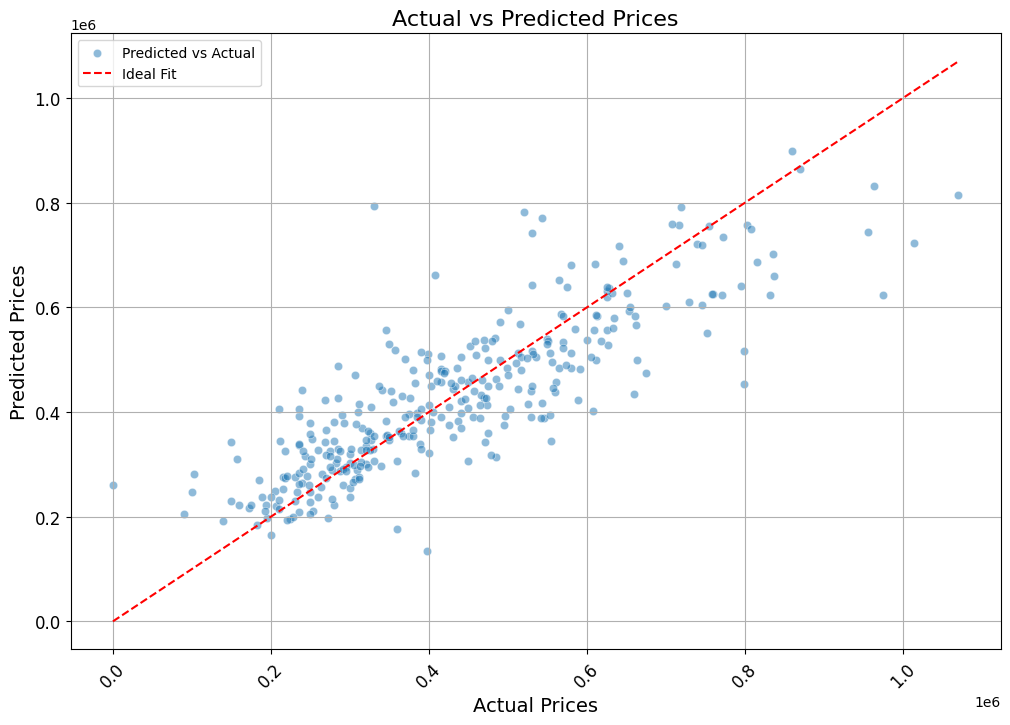

Mean Squared Error: 9750969499.72
R-squared: 0.71

Cross-Validation Scores: [0.66410774 0.6427131  0.63774365 0.66408133 0.68619264]
Mean CV Score: 0.66


In [24]:
# Visualize results
plt.figure(figsize=(12, 8))
plt.scatter(
    y_test,
    y_pred_final,
    alpha=0.5,
    edgecolors="w",
    linewidth=0.5,
    label="Predicted vs Actual",
)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    label="Ideal Fit",
)
plt.xlabel("Actual Prices", fontsize=14)
plt.ylabel("Predicted Prices", fontsize=14)
plt.title("Actual vs Predicted Prices", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred_final)
r_squared = r2_score(y_test, y_pred_final)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r_squared:.2f}')

# Cross-Validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f'\nCross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

## Conclusion

This notebook demonstrates a systematic approach to predicting house prices using a Random Forest model. Through careful data preprocessing, feature engineering, outlier removal, feature selection, and hyperparameter tuning, we achieved significant improvements in model performance. The final model achieved an R-squared value of 0.52 and an accuracy of 52.25%. This is our most accurate model.

